In [1]:
%load_ext autoreload
%autoreload 2
# imports

import pacsltk.pacs_util as pacs_util
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

pacs_util.prepare_matplotlib_cycler()

# To avoid type 3 fonts: http://phyletica.org/matplotlib-fonts/
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import parse_util

import os
import glob
from datetime import timedelta

import pacsltk
print(pacsltk.__version__)

0.2.0


In [2]:
# Config paths
# EXP_CONFIG_NAME_DEFAULT = 'bench1_sleep_rand2_1000_200'
# EXP_CONFIG_NAME_DEFAULT = 'autoscale_go_500_10k_5'
EXP_CONFIG_NAME_DEFAULT = 'autoscale_go_500_10k_5_rps'
exp_config_name = os.getenv("EXP_CONFIG_NAME", EXP_CONFIG_NAME_DEFAULT)
exp_file = f"configs/{exp_config_name}.json"
overview_file_glob = f"results/{exp_config_name}/overview*.csv"
overview_file = glob.glob(overview_file_glob)[0]

print('config name:', exp_config_name)
print('overview file:', overview_file)
print('experiment file:', exp_file)

config name: autoscale_go_500_10k_5_rps
overview file: results/autoscale_go_500_10k_5_rps/overview_res-2021-03-10_16-44-02.csv
experiment file: configs/autoscale_go_500_10k_5_rps.json


In [3]:
# get overview
overview_df = pd.read_csv(overview_file, index_col=0, parse_dates=True)
overview_df.head(8)

,target,rps,res_name,request_func,workload_name,is_rps,exp_time_mins
0,1,1,res-2021-03-08_17-20-05,autoscale_go_500_10k_5_rps,autoscale-go,True,60
1,1,2,res-2021-03-08_18-20-50,autoscale_go_500_10k_5_rps,autoscale-go,True,60
2,1,3,res-2021-03-08_19-21-25,autoscale_go_500_10k_5_rps,autoscale-go,True,60
3,1,5,res-2021-03-08_20-21-50,autoscale_go_500_10k_5_rps,autoscale-go,True,60
4,1,7,res-2021-03-08_21-22-12,autoscale_go_500_10k_5_rps,autoscale-go,True,60
5,1,10,res-2021-03-08_22-22-30,autoscale_go_500_10k_5_rps,autoscale-go,True,60
6,1,15,res-2021-03-08_23-22-47,autoscale_go_500_10k_5_rps,autoscale-go,True,60
7,1,20,res-2021-03-09_00-23-04,autoscale_go_500_10k_5_rps,autoscale-go,True,60


In [4]:
batch_seconds = 600

# func used on each batch (part of a single experiment logs)
parse_cols_funcs = {
    'conc_window_average': lambda df: df['conc_window_average'].mean(),
    'average_ready_count': lambda df: df['ready_count'].mean(),
}

# func used on each batch (part of a single experiment logs)
parse_req_cols_funcs = {
    'client_elapsed_time': lambda df: df['client_elapsed_time'].mean(),
    'lambda_over_n': lambda df: df['lambda_over_n'].mean(),
}

parse_res = []
for res_name in tqdm(overview_df['res_name']):
    res_logger_file = f"results/{exp_config_name}/{res_name}_logger.csv"
    df = parse_util.parse_logger_file(res_logger_file)
    parse_cols_res = parse_util.parse_batch_custom_funcs(df, batch_seconds, parse_cols_funcs)
    
    res_reqs_file = f"results/{exp_config_name}/{res_name}_reqs.csv"
    df_req = parse_util.parse_reqs_file(res_reqs_file)
    parse_req_res = parse_util.parse_batch_custom_funcs(df_req, batch_seconds, parse_req_cols_funcs)

    parse_cols_res.update(parse_req_res)

    parse_res.append(parse_cols_res)

parse_res_df = pd.DataFrame(data=parse_res)
parse_res_df.head()

  0%|          | 0/48 [00:00<?, ?it/s]

,conc_window_average_mean,conc_window_average_var,conc_window_average_se,conc_window_average_ci,average_ready_count_mean,average_ready_count_var,average_ready_count_se,average_ready_count_ci,client_elapsed_time_mean,client_elapsed_time_var,client_elapsed_time_se,client_elapsed_time_ci,lambda_over_n_mean,lambda_over_n_var,lambda_over_n_se,lambda_over_n_ci
0,0.261979,0.000103,0.004546,0.008911,2.000000,0.000000,0.000000,0.000000,0.517164,5.003137e-07,0.000316,0.000620,0.500000,0.000000,0.000000,0.000000
1,0.323012,0.000015,0.001721,0.003374,3.252174,0.007264,0.038117,0.074708,0.516380,2.534673e-07,0.000225,0.000441,0.626152,0.000162,0.005692,0.011156
2,0.325895,0.000207,0.006438,0.012618,4.723746,0.017819,0.059698,0.117007,0.516378,4.663714e-07,0.000305,0.000599,0.641616,0.000382,0.008736,0.017123
3,0.342411,0.000029,0.002403,0.004711,7.538758,0.012699,0.050397,0.098778,0.515987,1.912576e-07,0.000196,0.000383,0.667316,0.000123,0.004954,0.009711
4,0.349594,0.000021,0.002027,0.003972,10.248783,0.038650,0.087920,0.172324,0.516352,4.874898e-07,0.000312,0.000612,0.685415,0.000151,0.005498,0.010777


In [5]:
orig_overview_parsed_df = pd.concat([overview_df, parse_res_df], axis=1)
orig_overview_parsed_df.head()

,target,rps,res_name,request_func,workload_name,is_rps,exp_time_mins,conc_window_average_mean,conc_window_average_var,conc_window_average_se,...,average_ready_count_se,average_ready_count_ci,client_elapsed_time_mean,client_elapsed_time_var,client_elapsed_time_se,client_elapsed_time_ci,lambda_over_n_mean,lambda_over_n_var,lambda_over_n_se,lambda_over_n_ci
0,1,1,res-2021-03-08_17-20-05,autoscale_go_500_10k_5_rps,autoscale-go,True,60,0.261979,0.000103,0.004546,...,0.000000,0.000000,0.517164,5.003137e-07,0.000316,0.000620,0.500000,0.000000,0.000000,0.000000
1,1,2,res-2021-03-08_18-20-50,autoscale_go_500_10k_5_rps,autoscale-go,True,60,0.323012,0.000015,0.001721,...,0.038117,0.074708,0.516380,2.534673e-07,0.000225,0.000441,0.626152,0.000162,0.005692,0.011156
2,1,3,res-2021-03-08_19-21-25,autoscale_go_500_10k_5_rps,autoscale-go,True,60,0.325895,0.000207,0.006438,...,0.059698,0.117007,0.516378,4.663714e-07,0.000305,0.000599,0.641616,0.000382,0.008736,0.017123
3,1,5,res-2021-03-08_20-21-50,autoscale_go_500_10k_5_rps,autoscale-go,True,60,0.342411,0.000029,0.002403,...,0.050397,0.098778,0.515987,1.912576e-07,0.000196,0.000383,0.667316,0.000123,0.004954,0.009711
4,1,7,res-2021-03-08_21-22-12,autoscale_go_500_10k_5_rps,autoscale-go,True,60,0.349594,0.000021,0.002027,...,0.087920,0.172324,0.516352,4.874898e-07,0.000312,0.000612,0.685415,0.000151,0.005498,0.010777


# Make Workload Plots

In [6]:
# list all available columns
orig_overview_parsed_df.columns

Index(['target', 'rps', 'res_name', 'request_func', 'workload_name', 'is_rps',
       'exp_time_mins', 'conc_window_average_mean', 'conc_window_average_var',
       'conc_window_average_se', 'conc_window_average_ci',
       'average_ready_count_mean', 'average_ready_count_var',
       'average_ready_count_se', 'average_ready_count_ci',
       'client_elapsed_time_mean', 'client_elapsed_time_var',
       'client_elapsed_time_se', 'client_elapsed_time_ci',
       'lambda_over_n_mean', 'lambda_over_n_var', 'lambda_over_n_se',
       'lambda_over_n_ci'],
      dtype='object')

In [7]:
# filter for some values
plot_targets = [1,2,5,10]
overview_parsed_df = orig_overview_parsed_df[orig_overview_parsed_df['target'].isin(plot_targets)]
overview_parsed_df.head()

,target,rps,res_name,request_func,workload_name,is_rps,exp_time_mins,conc_window_average_mean,conc_window_average_var,conc_window_average_se,...,average_ready_count_se,average_ready_count_ci,client_elapsed_time_mean,client_elapsed_time_var,client_elapsed_time_se,client_elapsed_time_ci,lambda_over_n_mean,lambda_over_n_var,lambda_over_n_se,lambda_over_n_ci
0,1,1,res-2021-03-08_17-20-05,autoscale_go_500_10k_5_rps,autoscale-go,True,60,0.261979,0.000103,0.004546,...,0.000000,0.000000,0.517164,5.003137e-07,0.000316,0.000620,0.500000,0.000000,0.000000,0.000000
1,1,2,res-2021-03-08_18-20-50,autoscale_go_500_10k_5_rps,autoscale-go,True,60,0.323012,0.000015,0.001721,...,0.038117,0.074708,0.516380,2.534673e-07,0.000225,0.000441,0.626152,0.000162,0.005692,0.011156
2,1,3,res-2021-03-08_19-21-25,autoscale_go_500_10k_5_rps,autoscale-go,True,60,0.325895,0.000207,0.006438,...,0.059698,0.117007,0.516378,4.663714e-07,0.000305,0.000599,0.641616,0.000382,0.008736,0.017123
3,1,5,res-2021-03-08_20-21-50,autoscale_go_500_10k_5_rps,autoscale-go,True,60,0.342411,0.000029,0.002403,...,0.050397,0.098778,0.515987,1.912576e-07,0.000196,0.000383,0.667316,0.000123,0.004954,0.009711
4,1,7,res-2021-03-08_21-22-12,autoscale_go_500_10k_5_rps,autoscale-go,True,60,0.349594,0.000021,0.002027,...,0.087920,0.172324,0.516352,4.874898e-07,0.000312,0.000612,0.685415,0.000151,0.005498,0.010777


In [8]:
rps_ticks = overview_parsed_df['rps'].unique()

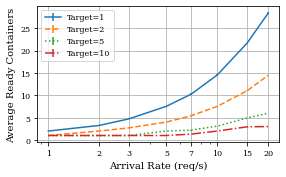

In [9]:
plt.figure(figsize=(4,2.5))
for target_value in overview_parsed_df['target'].unique():
    sub_df = overview_parsed_df.loc[overview_parsed_df['target'] == target_value, :]
    # plt.semilogx(sub_df['rps'], sub_df['average_ready_count_mean'])
    plt.errorbar(sub_df['rps'], sub_df['average_ready_count_mean'], yerr=sub_df['average_ready_count_ci'], label=f"Target={target_value}")

plt.gca().set_xscale('log')
plt.xticks(rps_ticks, rps_ticks)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.xlabel("Arrival Rate (req/s)")
plt.ylabel("Average Ready Containers")
plt.gcf().subplots_adjust(left=0.13, bottom=0.20)
parse_util.tmp_fig_save('01_average_ready_containers_vs_arrival_rate', exp_config_name)

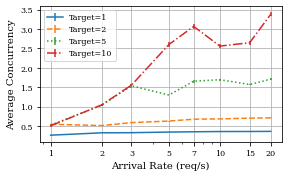

In [10]:
plt.figure(figsize=(4,2.5))
for target_value in overview_parsed_df['target'].unique():
    sub_df = overview_parsed_df.loc[overview_parsed_df['target'] == target_value, :]
    # plt.semilogx(sub_df['rps'], sub_df['conc_window_average_mean'])
    plt.errorbar(sub_df['rps'], sub_df['conc_window_average_mean'], yerr=sub_df['conc_window_average_ci'], label=f"Target={target_value}")

plt.gca().set_xscale('log')
plt.xticks(rps_ticks, rps_ticks)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.xlabel("Arrival Rate (req/s)")
plt.ylabel("Average Concurrency")
plt.gcf().subplots_adjust(left=0.13, bottom=0.20)
parse_util.tmp_fig_save('02_conc_window_average_vs_arrival_rate', exp_config_name)

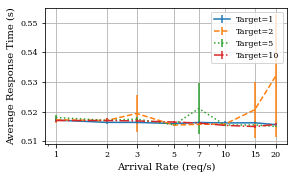

In [11]:
plt.figure(figsize=(4,2.5))
for target_value in overview_parsed_df['target'].unique():
    sub_df = overview_parsed_df.loc[overview_parsed_df['target'] == target_value, :]
    # plt.semilogx(sub_df['rps'], sub_df['conc_window_average_mean'])
    plt.errorbar(sub_df['rps'], sub_df['client_elapsed_time_mean'], yerr=sub_df['client_elapsed_time_ci'], label=f"Target={target_value}")

plt.gca().set_xscale('log')
plt.xticks(rps_ticks, rps_ticks)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.xlabel("Arrival Rate (req/s)")
plt.ylabel("Average Response Time (s)")
plt.gcf().subplots_adjust(left=0.13, bottom=0.20)
parse_util.tmp_fig_save('03_average_resp_time_vs_arrival_rate', exp_config_name)

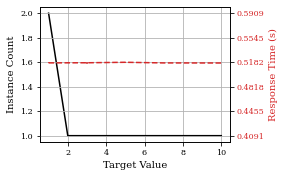

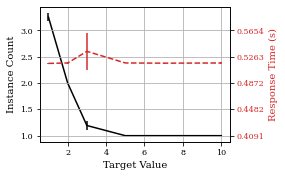

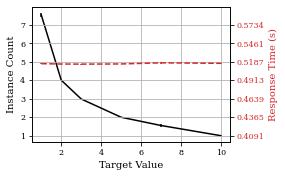

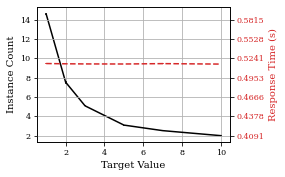

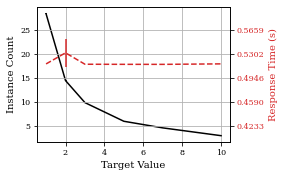

In [12]:
# let's see if we can make plots for effect of CC
from matplotlib import ticker

for plot_arrival_rate in [1,2,5,10,20]:
    sub_overview_df = orig_overview_parsed_df[orig_overview_parsed_df['rps'] == plot_arrival_rate]

    plt.figure(figsize=(4,2.5))
    color = 'k'
    ax1 = plt.gca()
    ax1.errorbar(sub_overview_df['target'], sub_overview_df['average_ready_count_mean'], yerr=sub_overview_df['average_ready_count_ci'], color=color)
    ax1.set_xlabel('Target Value')
    ax1.set_ylabel('Instance Count', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.grid(True, axis='x')

    color = 'tab:red'
    ax2 = plt.gca().twinx()
    ax2.errorbar(sub_overview_df['target'], sub_overview_df['client_elapsed_time_mean'], yerr=sub_overview_df['client_elapsed_time_ci'], ls='--', color=color)
    ax2.set_ylabel('Response Time (s)', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.grid(None)
    # ax2.set_ylim([0.4,0.6])

    # aligning ticks for grids
    l = ax1.get_ylim()
    l2 = ax2.get_ylim()
    f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
    ticks = f(ax1.get_yticks())
    ax2.yaxis.set_major_locator(ticker.FixedLocator(ticks))

    # final config
    plt.gcf().subplots_adjust(left=0.13, bottom=0.20)
    plt.tight_layout()

    parse_util.tmp_fig_save(f'04_inst_count_resp_time_target_arrival_{plot_arrival_rate}', exp_config_name)